<a href="https://colab.research.google.com/github/phitonthel/YOG1-C_Final_Project/blob/master/final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U efficientnet==1.1.0

In [ ]:
!git clone https://github.com/UCSD-AI4H/COVID-CT.git

Cloning into 'COVID-CT'...
remote: Enumerating objects: 5459, done.
remote: Total 5459 (delta 0), reused 0 (delta 0), pack-reused 5459
Receiving objects: 100% (5459/5459), 1.09 GiB | 16.05 MiB/s, done.
Resolving deltas: 100% (363/363), done.
Checking out files: 100% (1048/1048), done.


In [ ]:
!unzip "COVID-CT/Images-processed/CT_NonCOVID.zip" -d "dataset/"

Archive:  COVID-CT/Images-processed/CT_NonCOVID.zip
  inflating: dataset/CT_NonCOVID/0.jpg  
  inflating: dataset/CT_NonCOVID/1%0.jpg  
  inflating: dataset/CT_NonCOVID/1%1.jpg  
  inflating: dataset/CT_NonCOVID/1%2.jpg  
  inflating: dataset/CT_NonCOVID/10%0.jpg  
  inflating: dataset/CT_NonCOVID/10%1.jpg  
  inflating: dataset/CT_NonCOVID/10%2.jpg  
  inflating: dataset/CT_NonCOVID/102.png  
  inflating: dataset/CT_NonCOVID/1029.png  
  inflating: dataset/CT_NonCOVID/103.png  
  inflating: dataset/CT_NonCOVID/1030.png  
  inflating: dataset/CT_NonCOVID/104.png  
  inflating: dataset/CT_NonCOVID/1046.png  
  inflating: dataset/CT_NonCOVID/1047.png  
  inflating: dataset/CT_NonCOVID/1048.png  
  inflating: dataset/CT_NonCOVID/1049.png  
  inflating: dataset/CT_NonCOVID/1050.png  
  inflating: dataset/CT_NonCOVID/1058.png  
  inflating: dataset/CT_NonCOVID/1059.png  
  inflating: dataset/CT_NonCOVID/1060.png  
  inflating: dataset/CT_NonCOVID/1061.png  
  inflating: dataset/CT_NonCOVID/

In [ ]:
!unzip "COVID-CT/Images-processed/CT_COVID.zip" -d "dataset/"

Archive:  COVID-CT/Images-processed/CT_COVID.zip
   creating: dataset/CT_COVID/
  inflating: dataset/CT_COVID/2020.03.01.20029769-p21-73_1%1.png  
   creating: dataset/__MACOSX/
   creating: dataset/__MACOSX/CT_COVID/
  inflating: dataset/__MACOSX/CT_COVID/._2020.03.01.20029769-p21-73_1%1.png  
  inflating: dataset/CT_COVID/Recurrence-of-positive-SARS-CoV-2-RNA-in-C_2020_International-Journal-of-Inf-p1-21%1.png  
  inflating: dataset/__MACOSX/CT_COVID/._Recurrence-of-positive-SARS-CoV-2-RNA-in-C_2020_International-Journal-of-Inf-p1-21%1.png  
  inflating: dataset/CT_COVID/2020.03.12.20034686-p17-91-4.png  
  inflating: dataset/__MACOSX/CT_COVID/._2020.03.12.20034686-p17-91-4.png  
  inflating: dataset/CT_COVID/2020.02.25.20021568-p24-111%8.png  
  inflating: dataset/__MACOSX/CT_COVID/._2020.02.25.20021568-p24-111%8.png  
  inflating: dataset/CT_COVID/2020.03.13.20035212-p23-153.png  
  inflating: dataset/__MACOSX/CT_COVID/._2020.03.13.20035212-p23-153.png  
  inflating: dataset/CT_COVI

In [ ]:
import numpy as np # linear algebra
import random
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from efficientnet.tfkeras import EfficientNetB0, EfficientNetB7, EfficientNetB4

from sklearn.model_selection import train_test_split, KFold

import cv2
import shutil
from glob import glob
# Helper libraries
import matplotlib.pyplot as plt
import math
%matplotlib inline
print(tf.__version__)

import time

2.2.0


In [ ]:
data_root='/content/dataset/'
path_positive_cases = os.path.join('/content/dataset/CT_COVID/')
path_negative_cases = os.path.join('/content/dataset/CT_NonCOVID/')

### Datasets Overview 

In [ ]:
# jpg and png files
positive_images_ls = glob(os.path.join(path_positive_cases,"*.png"))

negative_images_ls = glob(os.path.join(path_negative_cases,"*.png"))
negative_images_ls.extend(glob(os.path.join(path_negative_cases,"*.jpg")))

In [ ]:
covid = {'class': 'CT_COVID',
         'path': path_positive_cases,
         'images': positive_images_ls}

non_covid = {'class': 'CT_NonCOVID',
             'path': path_negative_cases,
             'images': negative_images_ls}

In [ ]:
df = pd.DataFrame(columns=['height', 'width'])
liste = []

for img_name in os.listdir(path_positive_cases):
    img = cv2.imread(os.path.join(path_positive_cases, img_name))
    liste.append(img.shape[:-1])

for img_name in os.listdir(path_negative_cases):
    img = cv2.imread(os.path.join(path_negative_cases, img_name))
    liste.append(img.shape[:-1])

df['height'] = list(zip(*liste))[0]
df['width'] = list(zip(*liste))[1]

In [ ]:
total_positive_covid = len(positive_images_ls)
total_negative_covid = len(negative_images_ls)
print("Total Positive Cases Covid19 images: {}".format(total_positive_covid))
print("Total Negative Cases Covid19 images: {}".format(total_negative_covid))

Total Positive Cases Covid19 images: 349
Total Negative Cases Covid19 images: 397


### Create Train-Test Directory 

In [ ]:
# Create Train-Test Directory
subdir  = 'train/'

labeldirs = ['CT_COVID', 'CT_NonCOVID']
for labldir in labeldirs:
    newdir = subdir + labldir
    os.makedirs(newdir, exist_ok=True)
    
subdir  = 'test/'

labeldirs = ['CT_COVID', 'CT_NonCOVID']
for labldir in labeldirs:
    newdir = subdir + labldir
    os.makedirs(newdir, exist_ok=True)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

test_size=0.15
sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=3)

In [ ]:
data_full=[]
labels_full=[]
data_full = covid["images"].copy()
data_full.extend(non_covid["images"].copy())
labels_full = [covid["class"]] * len(covid["images"])
labels_full.extend([non_covid["class"]] * len(non_covid["images"]))

print(len(data_full), data_full[0], data_full[-1])
print(len(labels_full), labels_full[0], labels_full[-1])

746 /content/dataset/CT_COVID/2020.02.10.20021584-p6-52%8.png /content/dataset/CT_NonCOVID/70%0.jpg
746 CT_COVID CT_NonCOVID


In [ ]:
splitted_list = list(sss.split(data_full, labels_full))
train_index = splitted_list[0][0]
test_index = splitted_list[0][1]

In [ ]:
print("Splitted list : ", len(data_full))
print("Train index : ", len(train_index))
print("Test index : ", len(test_index))

Splitted list :  746
Train index :  634
Test index :  112


In [ ]:
# Copy Images to test set

list_of_random_files = []
for i in test_index:
    list_of_random_files.append([data_full[i], labels_full[i]])

print(len(list_of_random_files))
for f,l in list_of_random_files:
    shutil.copy2(f, 'test/' + l)

112


In [ ]:
# Copy Images to train set
list_of_random_files = []
for i in train_index:
    list_of_random_files.append([data_full[i], labels_full[i]])
    
print(len(list_of_random_files))
for f,l in list_of_random_files:
    shutil.copy2(f, 'train/' + l)

634


In [ ]:
total_train_covid = len(os.listdir('/content/train/CT_COVID'))
total_train_noncovid = len(os.listdir('/content/train/CT_NonCOVID'))
total_test_covid = len(os.listdir('/content/test/CT_COVID'))
total_test_noncovid = len(os.listdir('/content/test/CT_NonCOVID'))

print("Train sets images COVID: {}".format(total_train_covid))
print("Train sets images Non COVID: {}".format(total_train_noncovid))
print("Test sets images COVID: {}".format(total_test_covid))
print("Test sets images Non COVID: {}".format(total_test_noncovid))

Train sets images COVID: 297
Train sets images Non COVID: 337
Test sets images COVID: 52
Test sets images Non COVID: 60


### Efficient Net B0

In [ ]:
config_json = {
  "exp": {
    "name": "efficientnetb0_base_model"
  },
  "data_loader": {
    "name": "efficientnetb0_base_data_loader.Efficientnetb0BaseDataLoader",
    "train_dir": "/content/dataset_CUB_200_2011/images/train.csv",
    "test_dir": "/content/dataset_CUB_200_2011/images/test.csv"
  },
  "model":{
    "name": "efficientnetb0_base_model.Efficientnetb0BaseModel",
    "optimizer": "adam",
    "loss": "binary_crossentropy"
  },
  "trainer":{
    "name": "efficientnetb0_base_trainer.Efficientnetb0BaseTrainer",
    "num_epochs": 1,
    "batch_size": 32,
    "verbose_training": True
  },
  "callbacks":{
    "checkpoint_monitor": "val_loss",
    "checkpoint_mode": "min",
    "checkpoint_save_best_only": True,
    "checkpoint_save_weights_only": True,
    "checkpoint_verbose": True,
    "checkpoint_save_freq": "epoch",
    "tensorboard_write_graph": True
  }
}

In [ ]:
def extract_dir_to_df(root_dir: str)-> pd.DataFrame:
    dirnames = os.listdir(root_dir)
    dirnames = [dire for dire in dirnames 
                if os.path.isdir(os.path.join(root_dir, dire))]
    data = {'filepath': [],
            'class': []}

    for dir_ in sorted(dirnames):
        clsname = dir_.split('.')[0]
        list_dir = os.listdir(os.path.join(root_dir, dir_))
        for fname in list_dir:
            fullpath = os.path.join(root_dir, dir_, fname)
            if not os.path.isfile(fullpath):
                continue
            data['filepath'].append(fullpath)
            data['class'].append(clsname)
    return pd.DataFrame(data)


In [ ]:
class BaseModel:
    def __init__(self, config):
        self.config = config
        self.model = None

    def save(self, checkpoint_path):
        """Save weights to `checkpoint_path

        """
        if self.model is None:
            raise Exception("You have to build the model first.")

        print("Saving model...")
        self.model.save_weights(checkpoint_path)
        print("Model saved")

    def load(self, checkpoint_path):
        if self.model is None:
            raise Exception("You have to build the model first.")

        print("Loading model checkpoint {} ...\n".format(checkpoint_path))
        print("Model loaded")

    def build_model(self):
        raise NotImplementedError

class Efficientnetb0BaseModel(BaseModel):
    def __init__(self, config):
        super(Efficientnetb0BaseModel, self).__init__(config)
        self.build_model()

    def build_model(self):
        self.base_model=EfficientNetB0(weights='noisy-student', include_top=False)
        self.base_model.trainable= True

        self.x=self.base_model.output
        self.x=GlobalAveragePooling2D()(self.x)
        self.x=Dense(512, activation='relu')(self.x)
        self.x=Dropout(rate=0.2)(self.x)
        self.x=Dense(128, activation='relu')(self.x)
        self.x=Dropout(rate=0.2)(self.x)
        self.preds=Dense(1,activation='sigmoid')(self.x)

        self.model=Model(inputs=self.base_model.input,outputs=self.preds)

        self.model.compile(optimizer='adam',
                            loss='binary_crossentropy',
                            metrics=['accuracy'])

In [ ]:
def create_dirs(dirs):
    """
    dirs - a list of directories to create if these directories are not found
    :param dirs:
    :return exit_code: 0:success -1:failed
    """
    try:
        for dir_ in dirs:
            if not os.path.exists(dir_):
                os.makedirs(dir_)
        return 0
    except Exception as err:
        print("Creating directories error: {0}".format(err))
        exit(-1)

In [ ]:
class BaseTrain:
    def __init__(self, model, data, config):
        self.model = model
        self.data = data
        self.config = config

    def train(self):
        raise NotImplementedError

class Efficientnetb0BaseTrainer(BaseTrain):
    def __init__(self, model, data, config):
        super(Efficientnetb0BaseTrainer, self).__init__(model, data, config)
        self.callbacks = []
        self.loss = []
        self.accuracy = []
        self.val_loss = []
        self.val_accuracy = []
        
        self.tensorboard_log_dir = os.path.join("experiments", time.strftime("%Y-%m-%d/",time.localtime()), "ENetB7BaseSig", "logs/")
        self.checkpoint_dir = os.path.join("experiments", time.strftime("%Y-%m-%d/",time.localtime()), "ENetB7BaseSig", "checkpoints/")
        
        create_dirs([self.tensorboard_log_dir, self.checkpoint_dir])
        
        self.init_callbacks()
        
    def init_callbacks(self):
        #self.callbacks.append(
        #    #ModelCheckpoint(
        #        filepath=os.path.join(self.checkpoint_dir, '%s-{epoch:02d}-{val_loss:.2f}.hdf5' % "ENetBase"),
        #        monitor="val_loss",
        #        mode="min",
        #        save_best_only=True,
        #        save_freq="epoch",
        #        verbose=True,
        #    )
        #)

        self.callbacks.append(
            TensorBoard(
                log_dir=self.tensorboard_log_dir,
                write_graph=True,
            )
        )
        
        #self.callbacks.append(
        #    EarlyStopping(monitor="val_loss", mode="min", patience=10)
        #)

    def train(self, batch_size, epochs):
        train_flow_df, val_flow_df = self.data
        
        steps_per_epoch_train = len(train_flow_df)/batch_size
        steps_per_epoch_val = len(val_flow_df)/batch_size
        # Do not specify the batch_size if your data is in the form of datasets, generators, or 
        # keras.utils.Sequence instances (since they generate batches).
        history = self.model.fit(
            train_flow_df,
            epochs=epochs,
            steps_per_epoch=steps_per_epoch_train+1,
            verbose=True,
            validation_data=val_flow_df,
            validation_steps=steps_per_epoch_val+1,
            callbacks=self.callbacks,
            )
        self.loss.extend(history.history['loss'])
        self.accuracy.extend(history.history['accuracy'])
        self.val_loss.extend(history.history['val_loss'])
        self.val_accuracy.extend(history.history['val_accuracy'])

In [ ]:
batch_size = 32
epochs = 464
IMG_HEIGHT = 224
IMG_WIDTH = 224

df_train = extract_dir_to_df('/content/train')
df_test = extract_dir_to_df('/content/test')
train_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

len_train_cv = len(df_train)
len_valid_cv = len(df_test)


train_flow_df = train_image_generator.flow_from_dataframe(dataframe=df_train,
                                                            x_col='filepath',
                                                            y_col='class',
                                                            shuffle=True,
                                                            batch_size=batch_size,
                                                            seed=3,
                                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                            class_mode='binary')

test_flow_df = test_image_generator.flow_from_dataframe(dataframe=df_test,
                                                        x_col='filepath',
                                                        y_col='class',
                                                        shuffle=False,
                                                        batch_size=batch_size,
                                                        seed=3,
                                                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                        class_mode='binary')

model = Efficientnetb0BaseModel(config_json)
trainer = Efficientnetb0BaseTrainer(model.model, 
(train_flow_df, test_flow_df),
config_json)

trainer.train(batch_size, epochs)

Found 634 validated image filenames belonging to 2 classes.
Found 112 validated image filenames belonging to 2 classes.
Epoch 1/464
2/1 [====================================] - 3s 2s/step - loss: 0.7038 - accuracy: 0.4531 - val_loss: 0.6962 - val_accuracy: 0.4531
Epoch 2/464
2/1 [====================================] - 2s 774ms/step - loss: 0.6554 - accuracy: 0.6379 - val_loss: 0.7339 - val_accuracy: 0.4219
Epoch 3/464
2/1 [====================================] - 2s 762ms/step - loss: 0.5351 - accuracy: 0.7188 - val_loss: 0.6427 - val_accuracy: 0.6562
Epoch 4/464
2/1 [====================================] - 2s 759ms/step - loss: 0.5048 - accuracy: 0.7500 - val_loss: 0.8057 - val_accuracy: 0.4062
Epoch 5/464
2/1 [====================================] - 2s 764ms/step - loss: 0.4347 - accuracy: 0.7500 - val_loss: 0.7817 - val_accuracy: 0.4375
Epoch 6/464
2/1 [====================================] - 2s 762ms/step - loss: 0.3207 - accuracy: 0.8438 - val_loss: 0.6736 - val_accuracy: 0.6562
E

In [ ]:
cv_history_final = np.array([trainer.loss, trainer.accuracy, trainer.val_loss, trainer.val_accuracy])
np.save('cv_history_final.np', cv_history_final)

In [ ]:
cv_history_final

num_rows = 464

cv_history_final_df = pd.DataFrame({
    'epoch': range(num_rows),
    'loss': cv_history_final[0],
    'accuracy': cv_history_final[1],
    'val_loss': cv_history_final[2],
    'val_accuracy': cv_history_final[3]
})

print(cv_history_final_df)

     epoch      loss  accuracy  val_loss  val_accuracy
0        0  0.703794  0.453125  0.696180      0.453125
1        1  0.655437  0.637931  0.733872      0.421875
2        2  0.535119  0.718750  0.642729      0.656250
3        3  0.504844  0.750000  0.805676      0.406250
4        4  0.434657  0.750000  0.781744      0.437500
..     ...       ...       ...       ...           ...
459    459  0.008915  1.000000  0.640907      0.843750
460    460  0.001822  1.000000  0.713446      0.843750
461    461  0.001294  1.000000  0.766312      0.843750
462    462  0.001592  1.000000  0.806836      0.843750
463    463  0.001715  1.000000  0.842341      0.843750

[464 rows x 5 columns]


In [ ]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


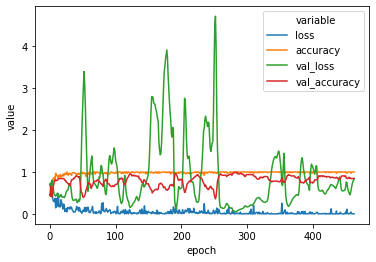

In [ ]:
sns.lineplot(x='epoch', y='value', hue='variable', 
             data=pd.melt(cv_history_final_df, ['epoch']))

In [ ]:
trainer.model.evaluate(test_flow_df)

4/4 [==============================] - 1s 128ms/step - loss: 0.4822 - accuracy: 0.9107


[0.48218968510627747, 0.9107142686843872]

### Save Final Model

In [ ]:
import tempfile

In [ ]:
_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(trainer.model, keras_file, include_optimizer=False)
print('Saved final model to:', keras_file)

Saved final model to: /tmp/tmp4zozdpgq.h5


### TFLite

In [ ]:
model_dir='/tmp/tmp4zozdpgq.h5'

from tensorflow.keras.models import load_model

loaded_model = load_model(model_dir)
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

loaded_model.evaluate(test_flow_df)

4/4 [==============================] - 0s 123ms/step - loss: 0.4822 - accuracy: 0.9107


[0.48218968510627747, 0.9107142686843872]

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()

_, tflite_file = tempfile.mkstemp('.tflite')

with open(tflite_file, 'wb') as f:
  f.write(tflite_model)

print('Saved TFLite model to:', tflite_file)

ValueError: ignored

In [ ]:
loaded_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 3 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 3 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [ ]:
import functools
from tensorflow import keras
import os
from efficientnet import model
from tensorflow.keras.utils import CustomObjectScope, get_custom_objects

def inject_keras_modules(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        kwargs['backend'] = keras.backend
        kwargs['layers'] = keras.layers
        kwargs['models'] = keras.models
        kwargs['utils'] = keras.utils
        return func(*args, **kwargs)

    return wrapper
def init_keras_custom_objects():
    custom_objects = {
        'swish': inject_keras_modules(model.get_swish)(),
        'FixedDropout': inject_keras_modules(model.get_dropout)()
    }

    get_custom_objects().update(custom_objects)

init_keras_custom_objects()
wk_keras_model_path = '/tmp/tmp4zozdpgq.h5'
wk_save_model = tf.keras.models.load_model(wk_keras_model_path)
wk_export_dir='save'
tf.saved_model.save(wk_save_model, wk_export_dir)
wk_new_model = tf.saved_model.load(wk_export_dir)

IMAGE_WIDTH = 224 # example
with CustomObjectScope({'swish': inject_keras_modules(model.get_swish)(),
                        'FixedDropout': inject_keras_modules(model.get_dropout)()}):
    concrete_func = wk_new_model.signatures[
        tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
    concrete_func.inputs[0].set_shape([1, IMAGE_WIDTH, IMAGE_WIDTH, 3])
    converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])

concrete_func = wk_new_model.signatures[
        tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([1, IMAGE_WIDTH, IMAGE_WIDTH, 3])
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])

MODEL_OUTPUT_PATH = "efficient_net_b0.tflite"
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter.allow_custom_ops = True
tflite_model = converter.convert()
open(MODEL_OUTPUT_PATH, "wb").write(tflite_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: save/assets


4886400

In [ ]:
!ls -la /content/efficient_net_b0.tflite

-rw-r--r-- 1 root root 4886400 Jun 22 12:05 /content/efficient_net_b0.tflite
